# Heatmap and tables, Figure1, S1

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap

In [3]:
print(sys.version)

3.7.4 (default, Jan  6 2021, 18:10:47) 
[Clang 11.0.3 (clang-1103.0.32.29)]


In [76]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "seaborn" -e "lifelines"

lifelines                         0.25.10
matplotlib                        3.3.4
numpy                             1.19.5
pandas                            1.2.3
scipy                             1.6.1
seaborn                           0.11.1
You should consider upgrading via the '/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [6]:
store="../results/"

In [7]:
# import data
df=pd.read_csv("../data/TCGA_integrated_data_after_clustering.tsv"
               ,sep="\t",index_col=0)

In [8]:
# import germline data
germ=pd.read_csv("../data/TCGA_germline_info.tsv",sep="\t",index_col=0)
df=pd.merge(df,germ,left_index=True,right_index=True,how="left")
df[germ.columns]=df[germ.columns].fillna(0)

In [9]:
df["BRCA12_alt"]=(np.nansum(df.reindex(["gBRCA1_LOH","gBRCA2_LOH","sBRCA1_LOH","sBRCA2_LOH","BRCA2_homdel","BRCA1_methylation"],axis=1),axis=1) >=1).astype(float)
df["MMR_mut"]=(np.nansum(df.reindex(["sMMR_mut","gMMR_mut"],axis=1),axis=1) >=1).astype(float)

In [10]:
cluster_colors=['red', 'blue', 'green', "brown", 'purple', 'hotpink',"c",'y']
dict_cluster_colors={"SMK":'red', "UVL":'blue', "APB":'green', "POL":'brown', "MRD":'purple',\
                     "HRD":'hotpink',"GNS":"c","AGE":"y",np.nan:"grey"}
cluster_orders=["SMK","UVL","APB","POL","MRD","HRD","GNS","AGE"]
dict_cluster_order_number={ "SMK":0,"UVL":1,"APB":2,"POL":3,"MRD":4,"HRD":5,"GNS":6,"AGE":7,np.nan:8}

In [11]:
# make cancer colors
rgbs1=sns.color_palette("tab20", 20)
rgbs2=sns.color_palette("tab20b", 20)
rgbs1_3=[] 
for i,x in enumerate(rgbs1):
    if (i%4)!=0:
        rgbs1_3.append(x)
rgbs2_3=[] 
for i,x in enumerate(rgbs2):
    if (i%4)!=0:
        rgbs2_3.append(x)

cancer30_colors = sns.color_palette(rgbs1_3+rgbs2_3, 30)

In [12]:
cancers_freq_order=[x[0] for x in Counter( df["CancerType"]).most_common()]

In [13]:
dict_cancer_colors={ cancer:color for cancer,color in zip(cancers_freq_order,cancer30_colors)}
dict_cancer_colors["Others"]="whitesmoke"
dict_cancer_colors[""]="whitesmoke"

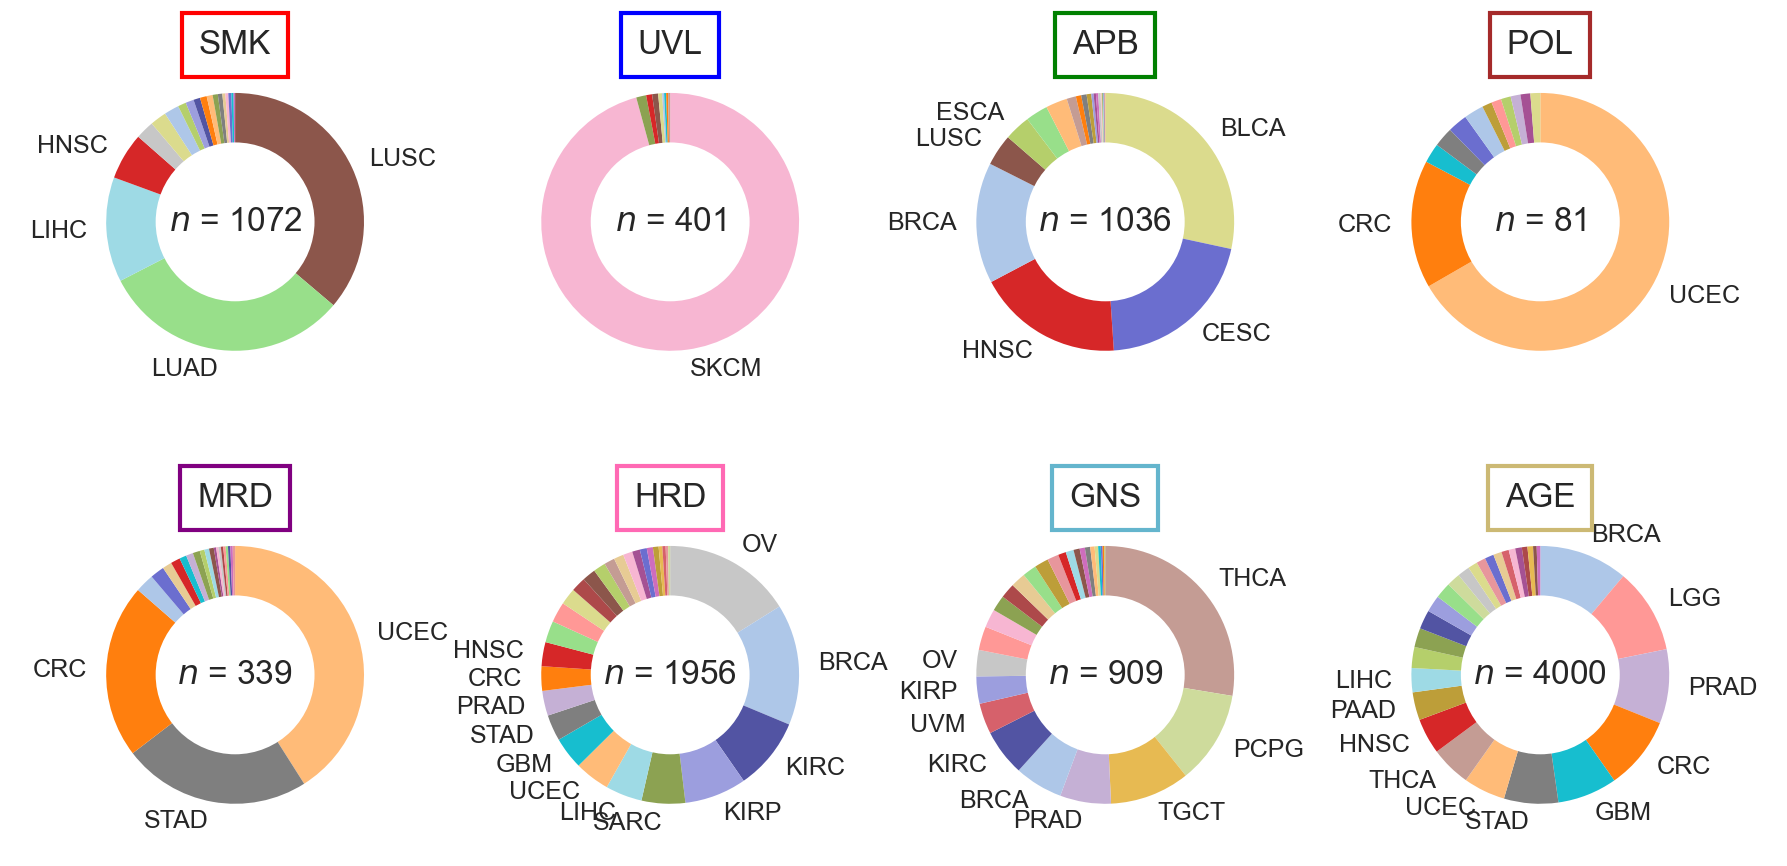

In [14]:
# pie chart
fig = plt.figure(figsize=(7,4))
names=cluster_orders
for j,name in enumerate(names):
    sns_df=df[ df["cluster_m2_names"]==name]
    ax = fig.add_subplot(2,4,j+1)
    counter=Counter(sns_df["CancerType"])
    counter_order=counter.most_common()
    cancer_order=[ x[0] for x in counter_order ]
    counts_order=[ counter[x] for x in cancer_order]
    labels=[cancer if counter[cancer]/len(sns_df)>=0.03 else "" for cancer in cancer_order]
    colors=[dict_cancer_colors[x] for x in cancer_order]
    ax.pie(counts_order, explode=None, labels=labels, colors=colors, autopct=None,
                          pctdistance=0.6, shadow=False, labeldistance=1.15,
                          startangle=90, radius=1, counterclock=False,
                        center=(0, 0),
                          frame=False,  data=None,
              wedgeprops={'linewidth': 0, 'edgecolor':"white"},
              textprops={"size":6})
    ax.text(0.5,0.5,"$n$ = "+str(len(sns_df)),transform=ax.transAxes,fontsize=8,
               ha="center",va="center")
    circle = patches.Circle(xy=(0, 0), radius=0.6, fc='w', ec='w')
    ax.add_patch(circle)
    ax.set_title(name,size=8,ha="center",va="bottom",
                 bbox=dict(facecolor="w",edgecolor=dict_cluster_colors[name],
                          fill=True,linewidth=1),pad=0)
plt.subplots_adjust(wspace=0.35,hspace=0)
#plt.savefig(store+"pie_chart_8subtype_cancertype.png",dpi=300,bbox_inches="tight")

# Heatmap

In [15]:
bwr=LinearSegmentedColormap.from_list('bwr', [(0,"blue"),(0.5,"w"),(1,"red")] )
wk=LinearSegmentedColormap.from_list('wk', [(0,"w"),(1,"k")] )
wr=LinearSegmentedColormap.from_list('wr', [(0,"w"),(1,"red")] )

In [16]:
# set colors
mask_color="w"
dict_translation={"0":mask_color, "1":"k","0.0":mask_color,"1.0":"k",0:mask_color,1:"k",
                 "Unknown":mask_color,"nan":mask_color,"Others":mask_color, "":mask_color }
dict_translation.update(dict_cluster_colors) 

In [17]:
df["AGE_z"]=stats.zscore(df["AGE"],nan_policy="omit")

Age
Sex_Female
AdvStage
Death
Smoking
HPV_status


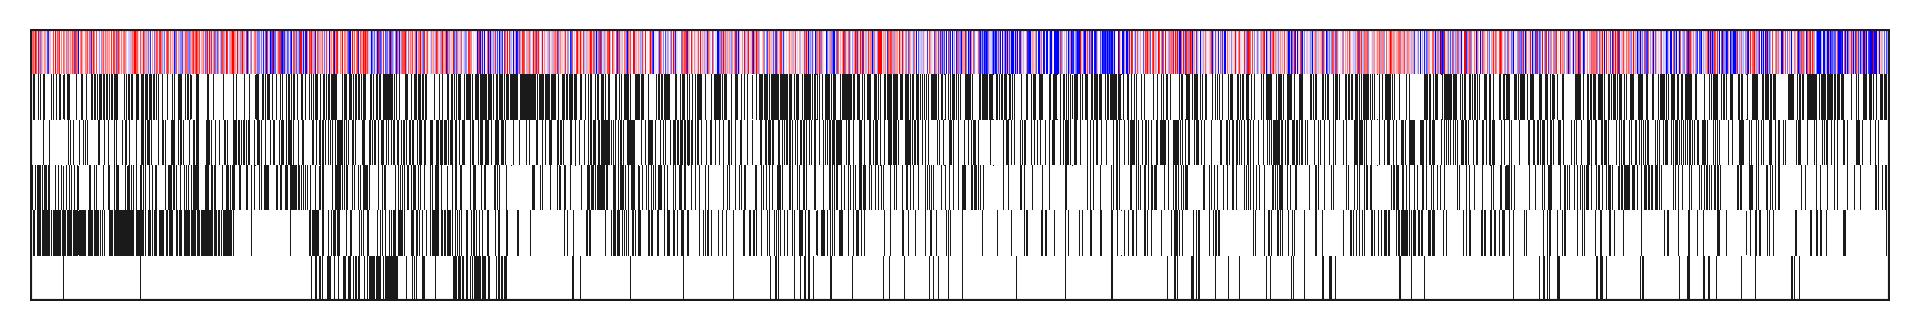

In [18]:
cat_list=["Age","Sex_Female","AdvStage","Death","Smoking","HPV_status"]
n=len(cat_list)

fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    if cat =="Age":
        sns.heatmap(df[["AGE_z"]].T,cmap=bwr,vmin=-1.5,vmax=1.5,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    else:
        sns.heatmap(df[[cat]].T,cmap=wk,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    if i==n-1:
        ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_clinical_info.png",dpi=300,bbox_inches="tight")

cluster_m2_names


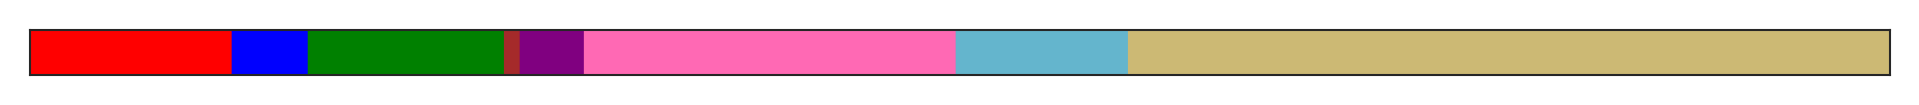

In [19]:
cat_list=["cluster_m2_names"]
n=len(cat_list)
fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    for j in range(N):
        val=str( input_df[cat][j] )
        r=patches.Rectangle(xy=(j/N,0),width=1/N,height=1,color=dict_translation[val])
        ax.add_patch(r)
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_subtype.png",dpi=300,bbox_inches="tight")

sPOLE_mut
MSI_high
MMR_mut
MLH1_methylation
BRCA12_alt


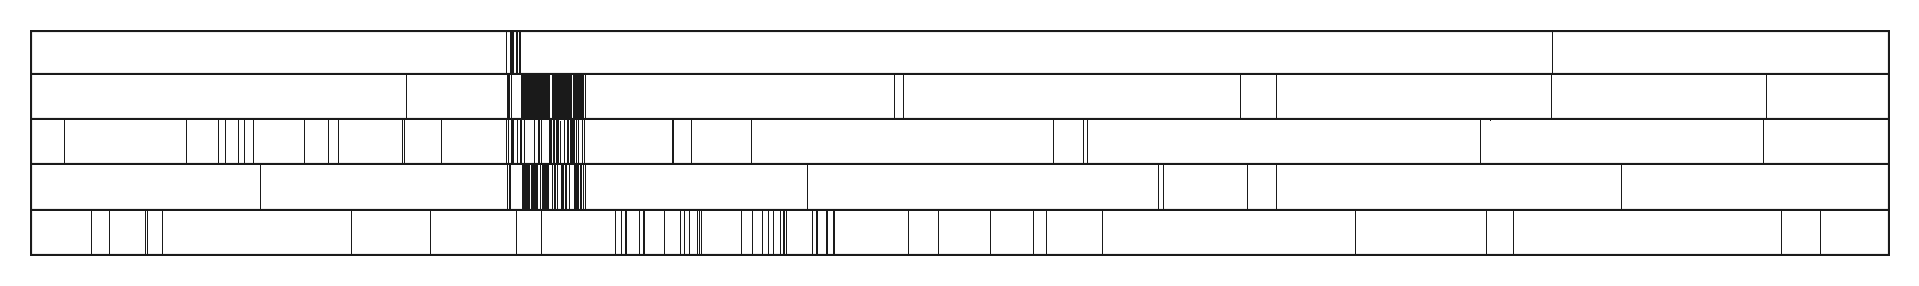

In [20]:
cat_list=["sPOLE_mut","MSI_high","MMR_mut","MLH1_methylation","BRCA12_alt"]
n=len(cat_list)
fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(df[[cat]].T,cmap=wk,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_genomic_info.png",dpi=300,bbox_inches="tight")

In [21]:
df["TMB_log10_z"]=stats.zscore(df["TMB_log10"],nan_policy="omit")

TMB_log10_z


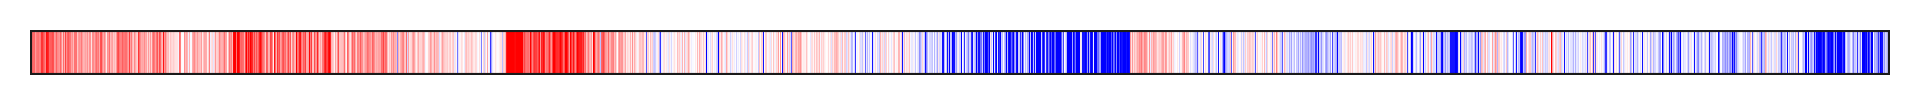

In [22]:
cont_list=["TMB_log10_z"]
n=len(cont_list)
fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cont_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns_df=input_df[[cat]].T
    sns.heatmap(sns_df,vmin=-2,vmax=2,ax=ax,cmap=bwr,cbar=False,xticklabels=0,yticklabels=0,
               linewidths=0)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    if i==n-1:
        ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)

plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_TMB.png",dpi=300,bbox_inches="tight")

In [23]:
cont_list=["CD8A_log_z","GZMB_log_z","IFNG_log_z","PDCD1_log_z","CTLA4_log_z",
           "CYT_log_z","GEP_score_z",]

CD8A_log_z
GZMB_log_z
IFNG_log_z
PDCD1_log_z
CTLA4_log_z
CYT_log_z
GEP_score_z


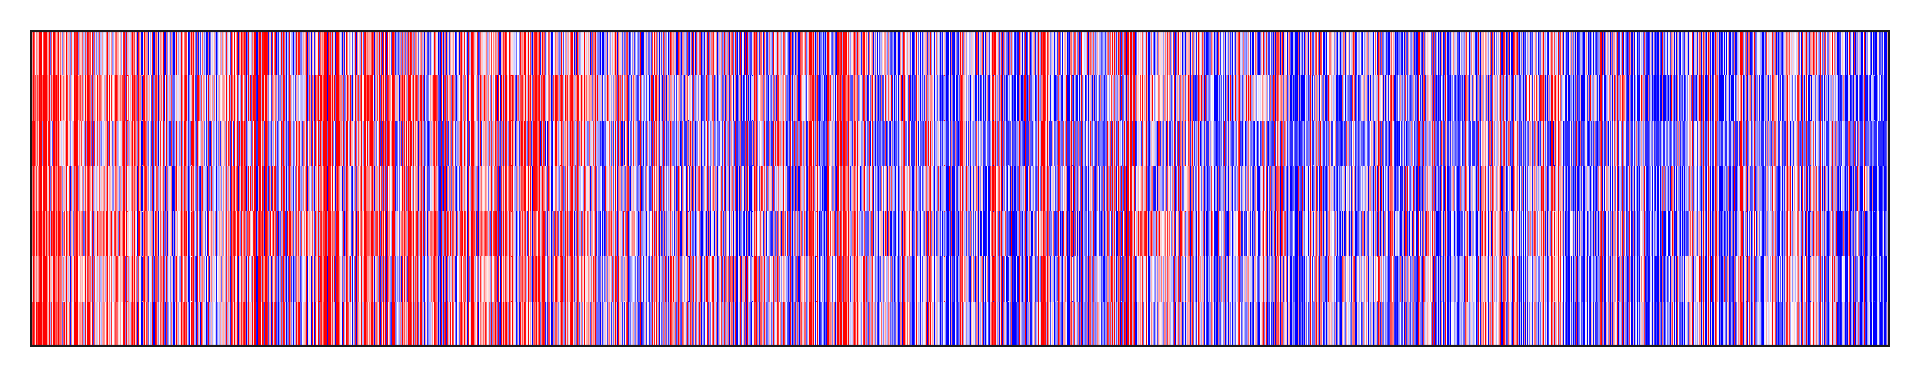

In [24]:
n=len(cont_list)
fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cont_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns_df=input_df[[cat]].T
    sns.heatmap(sns_df,vmin=-1.25,vmax=1.25,ax=ax,cmap=bwr,cbar=False,xticklabels=0,yticklabels=0,
               linewidths=0)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    if i==n-1:
        ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)

plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_gexp.png",dpi=300,bbox_inches="tight")

In [25]:
approved_order=[ 'LUAD', 'LUSC', "HNSC",'SKCM','BLCA', 'KIRC', 'LIHC', 'KIRP', 'STAD','CESC',  'ESCA',
                 'BRCA','CRC',
                 'UCEC', 'LGG', 'PRAD', 'THCA',  'OV', 'SARC', 'PCPG', 'PAAD', 'GBM','TGCT', 'MESO', 'UVM', 'ACC', 'KICH', 'UCS', 'CHOL']

In [26]:
dummy_cancertype=pd.get_dummies(df["CancerType"])

LUAD
LUSC
HNSC
SKCM
BLCA
KIRC
LIHC
KIRP
STAD
CESC
ESCA


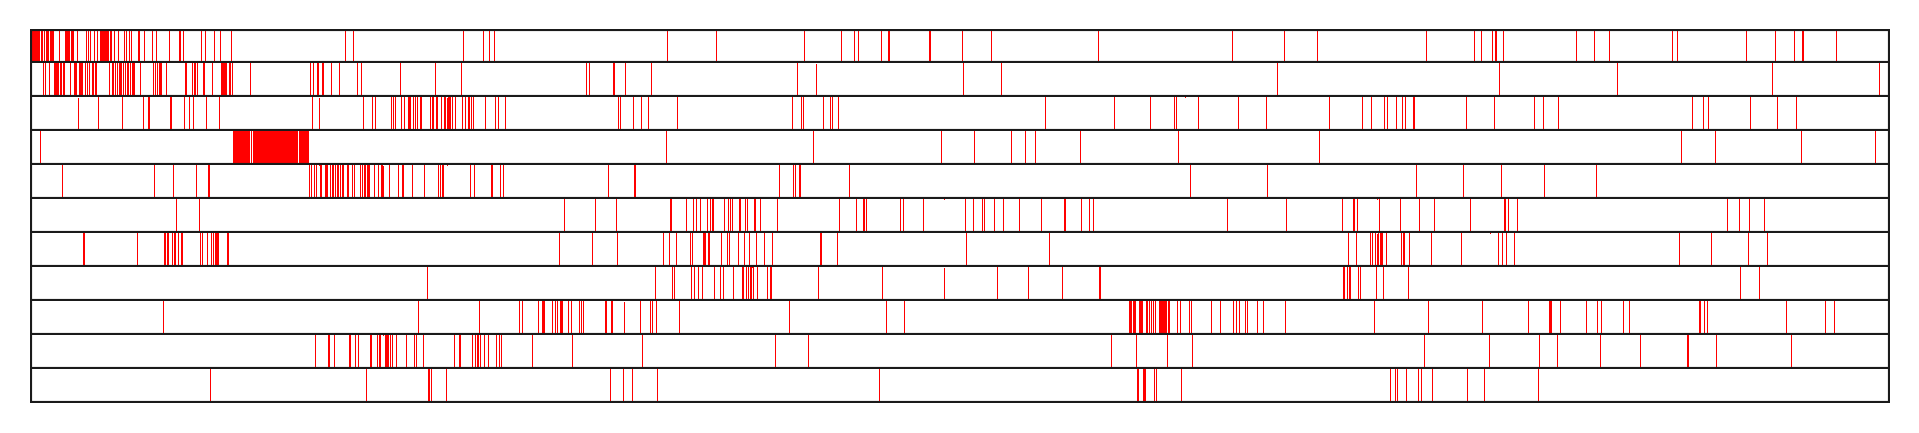

In [27]:
cat_list=approved_order[0:11]
n=len(cat_list)
fig=plt.figure(figsize=(8, 0.15*n))
input_df=dummy_cancertype.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(input_df[[cat]].T,cmap=wr,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_cancer_type1.png",dpi=300,bbox_inches="tight")

BRCA
CRC
UCEC
LGG
PRAD
THCA
OV
SARC
PCPG
PAAD
GBM
TGCT
MESO
UVM
ACC
KICH
UCS
CHOL


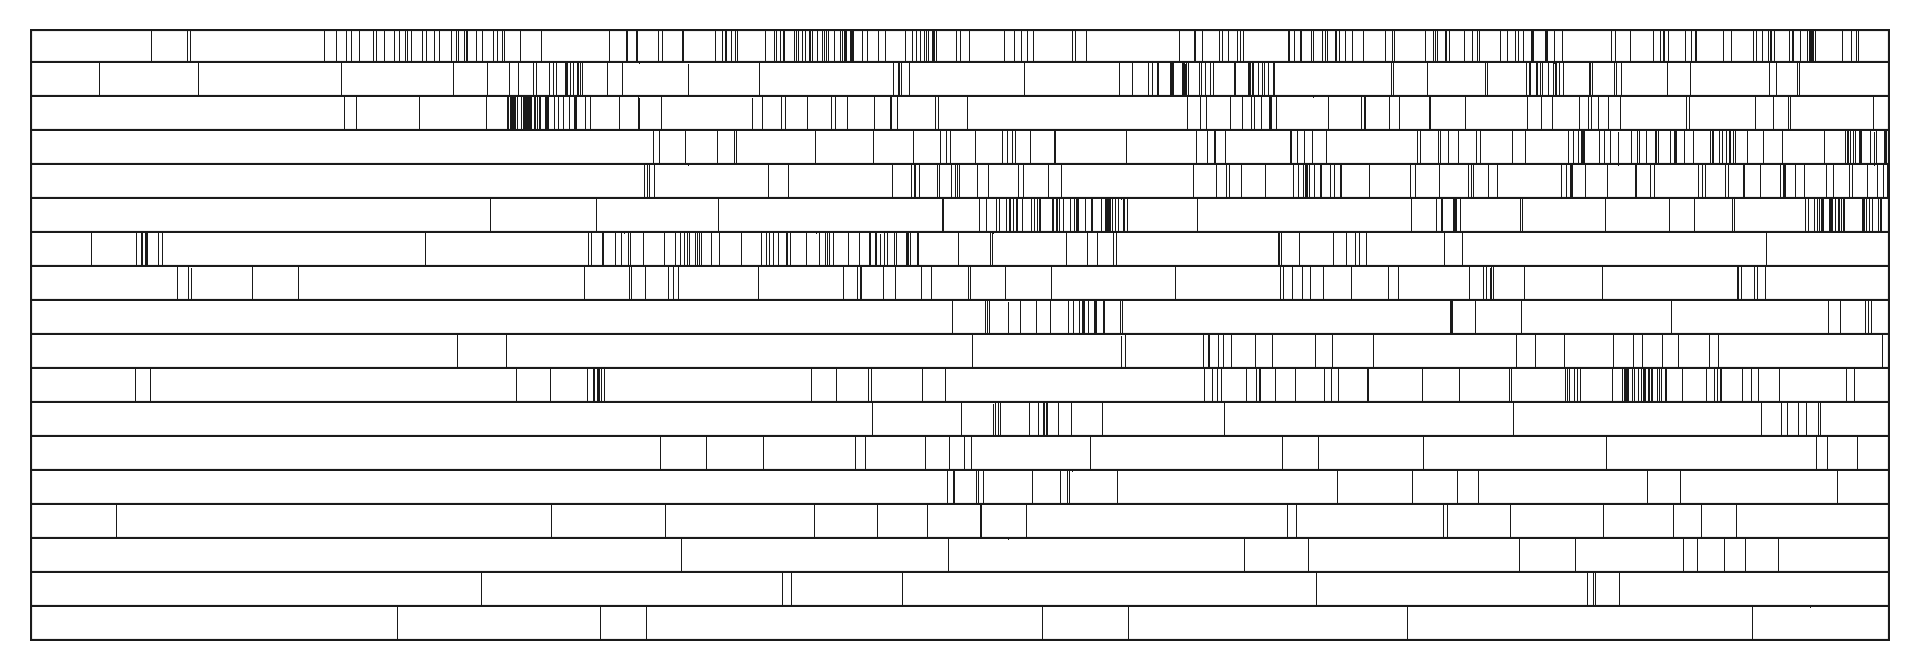

In [28]:
cat_list=approved_order[11:]
n=len(cat_list)
fig=plt.figure(figsize=(8, 0.15*n))
input_df=dummy_cancertype.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(input_df[[cat]].T,cmap=wk,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_cancer_type2.png",dpi=300,bbox_inches="tight")

In [29]:
df["FDA_approved"]=( df["CancerType"].isin(approved_order[0:11]) | (df["MSI_high"]>=1) ).astype(float)

FDA_approved


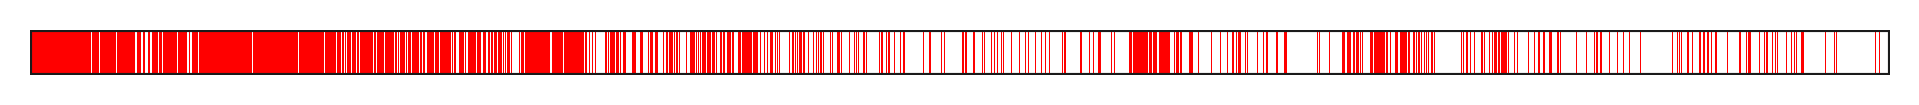

In [30]:
cat_list=["FDA_approved"]
n=len(cat_list)
fig=plt.figure(figsize=(8, 0.2*n))
input_df=df.copy()
N=input_df.shape[0]
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(df[[cat]].T,cmap=wr,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"Cluster_dendrogram_by_mutect2_FDA_approval.png",dpi=300,bbox_inches="tight")

# Table summary

([], [])

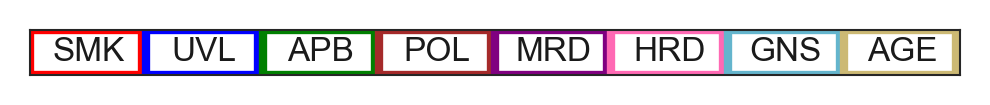

In [31]:
n=8
colors=cluster_colors
names=cluster_orders

fig = plt.figure(figsize=(4,0.2))
ax = fig.add_subplot(111)
for i,color in enumerate(colors):
    r=patches.Rectangle(xy=(i/n,0),width=1/(n+0.3),height=1,edgecolor=color,facecolor="w",lw=2)
    ax.add_patch(r)
    text=names[i]
    ax.text(x=(i+0.5)/n,y=0.5,s=text,fontsize=8, ha="center",va="center", color="k")

plt.xticks([])
plt.yticks([])
#plt.savefig(store+"table_labels.png",dpi=300,bbox_inches="tight")

In [32]:
# AGE
age_by_cluster=pd.DataFrame(df.groupby(by="cluster_m2_names").mean()["AGE"]).T
age_by_cluster=age_by_cluster.loc[:,cluster_orders]

age_by_cluster_z=pd.DataFrame(df.groupby(by="cluster_m2_names").mean()["AGE_z"]).T
age_by_cluster_z=age_by_cluster_z.loc[:,cluster_orders]

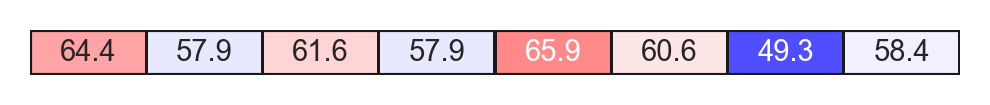

In [33]:
sns_df1=age_by_cluster
sns_df2=age_by_cluster_z

N=sns_df1.shape[0]
fig=plt.figure(figsize=(4,0.2*N))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,vmin=-1,vmax=1,cmap=bwr,annot=sns_df1,fmt=".3g",
           xticklabels=0,yticklabels=0,cbar=False,ax=ax,annot_kws={"fontsize":7},linecolor="k",linewidths=0.5)
ax.set_xlabel("")

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)
#plt.savefig(store+"table_summary_age.png",dpi=300,bbox_inches="tight")

In [34]:
# category1
selected_cat=["Sex_Female","AdvStage","Death","Smoking","HPV_status"]
tmp_df=df[selected_cat].astype(float).astype(str)
selected_cat_dummies=pd.get_dummies( tmp_df)
selected_cat_dummies["cluster_m2_names"]=df["cluster_m2_names"]
category_sum=selected_cat_dummies.groupby("cluster_m2_names").sum()
category_sum

,Sex_Female_0.0,Sex_Female_1.0,AdvStage_0.0,AdvStage_1.0,AdvStage_nan,Death_0.0,Death_1.0,Death_nan,Smoking_0.0,Smoking_1.0,Smoking_nan,HPV_status_0.0,HPV_status_1.0,HPV_status_nan
cluster_m2_names,,,,,,,,,,,,,,
AGE,2032.0,1968.0,1593.0,1067.0,1340.0,2834.0,1163.0,3.0,449.0,273.0,3278.0,149.0,74.0,3777.0
APB,439.0,597.0,523.0,495.0,18.0,695.0,341.0,0.0,415.0,335.0,286.0,154.0,248.0,634.0
GNS,441.0,468.0,477.0,204.0,228.0,778.0,131.0,0.0,81.0,30.0,798.0,7.0,4.0,898.0
HRD,791.0,1165.0,854.0,755.0,347.0,1257.0,699.0,0.0,269.0,169.0,1518.0,51.0,25.0,1880.0
MRD,90.0,249.0,237.0,82.0,20.0,266.0,73.0,0.0,11.0,6.0,322.0,6.0,4.0,329.0
POL,14.0,67.0,57.0,19.0,5.0,73.0,8.0,0.0,2.0,3.0,76.0,2.0,0.0,79.0
SMK,659.0,413.0,750.0,290.0,32.0,657.0,415.0,0.0,179.0,635.0,258.0,59.0,7.0,1006.0
UVL,257.0,144.0,209.0,159.0,33.0,224.0,177.0,0.0,4.0,4.0,393.0,3.0,0.0,398.0


In [35]:
dict_cat_cluster_ratio={}
for cat in selected_cat:
    dict_cat_cluster_ratio[cat]={}
    for cluster in cluster_orders:
        ones=category_sum.loc[cluster,cat+"_1.0"]
        if cat in ["HPV_status","Smoking"]:
            total=category_sum.loc[cluster, cat+"_0.0",]+category_sum.loc[cluster,cat+"_1.0"]+\
            category_sum.loc[cluster, cat+"_nan"]
        else:
            total=category_sum.loc[cluster, cat+"_0.0",]+category_sum.loc[cluster,cat+"_1.0"]
        ratio=100 * ones/total
        dict_cat_cluster_ratio[cat][cluster]=ratio

df_cat_cluster_ratio1=pd.DataFrame.from_dict( dict_cat_cluster_ratio ).T
df_cat_cluster_ratio1

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
Sex_Female,38.526119,35.910224,57.625483,82.716049,73.451327,59.560327,51.485149,49.200000
AdvStage,27.884615,43.206522,48.624754,25.000000,25.705329,46.923555,29.955947,40.112782
Death,38.712687,44.139651,32.915058,9.876543,21.533923,35.736196,14.411441,29.096823
Smoking,59.235075,0.997506,32.335907,3.703704,1.769912,8.640082,3.300330,6.825000
HPV_status,0.652985,0.000000,23.938224,0.000000,1.179941,1.278119,0.440044,1.850000


In [36]:
from sklearn.preprocessing import minmax_scale
tmp_df=df_cat_cluster_ratio1.copy()
df_cat_cluster_ratio1_a=pd.DataFrame( minmax_scale(tmp_df,axis=1), index=tmp_df.index,columns=tmp_df.columns)

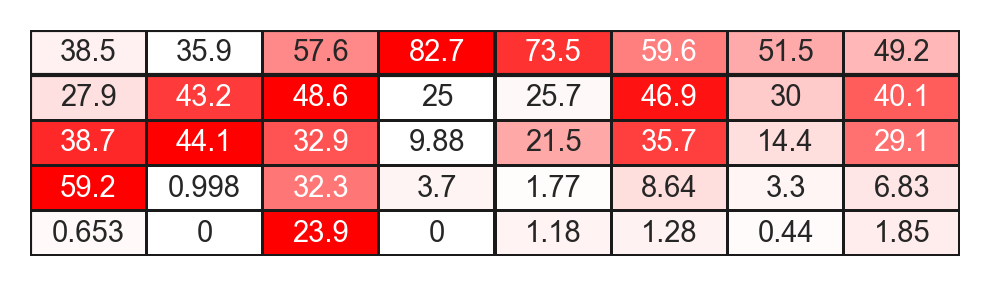

In [37]:
sns_df1=df_cat_cluster_ratio1
sns_df2=df_cat_cluster_ratio1_a

N=sns_df1.shape[0]
fig=plt.figure(figsize=(4,0.2*N))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,vmin=0,vmax=1,cmap=wr,annot=sns_df1,fmt=".3g",
           xticklabels=0,yticklabels=0,cbar=False,ax=ax,annot_kws={"fontsize":7},linecolor="k",linewidths=0.5)
ax.set_xlabel("")

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)

#plt.savefig(store+"table_summary_clinical.png",dpi=300,bbox_inches="tight")

In [38]:
# category2
selected_cat=["sPOLE_mut","MSI_high","MMR_mut","MLH1_methylation","BRCA12_alt"]
tmp_df=df[selected_cat].astype(float).astype(str)
selected_cat_dummies=pd.get_dummies( tmp_df)
selected_cat_dummies["cluster_m2_names"]=df["cluster_m2_names"]
category_sum=selected_cat_dummies.groupby("cluster_m2_names").sum()
category_sum

,sPOLE_mut_0.0,sPOLE_mut_1.0,MSI_high_0.0,MSI_high_1.0,MSI_high_nan,MMR_mut_0.0,MMR_mut_1.0,MLH1_methylation_0.0,MLH1_methylation_1.0,MLH1_methylation_nan,BRCA12_alt_0.0,BRCA12_alt_1.0
cluster_m2_names,,,,,,,,,,,,
AGE,3998.0,2.0,3935.0,19.0,46.0,3978.0,22.0,3537.0,21.0,442.0,3982.0,18.0
APB,1036.0,0.0,1027.0,4.0,5.0,1013.0,23.0,987.0,4.0,45.0,1022.0,14.0
GNS,909.0,0.0,898.0,3.0,8.0,904.0,5.0,822.0,0.0,87.0,895.0,14.0
HRD,1956.0,0.0,1896.0,13.0,47.0,1939.0,17.0,1587.0,4.0,365.0,1767.0,189.0
MRD,339.0,0.0,17.0,309.0,13.0,244.0,95.0,87.0,223.0,29.0,335.0,4.0
POL,19.0,62.0,60.0,19.0,2.0,33.0,48.0,65.0,11.0,5.0,80.0,1.0
SMK,1072.0,0.0,1053.0,7.0,12.0,1053.0,19.0,1006.0,6.0,60.0,1046.0,26.0
UVL,401.0,0.0,398.0,0.0,3.0,389.0,12.0,316.0,2.0,83.0,399.0,2.0


In [39]:
dict_cat_cluster_ratio={}
for cat in selected_cat:
    dict_cat_cluster_ratio[cat]={}
    for cluster in cluster_orders:
        ones=category_sum.loc[cluster,cat+"_1.0"]
        if cat in ["MLH1_methylation"]:
            total=category_sum.loc[cluster, cat+"_0.0",]+category_sum.loc[cluster,cat+"_1.0"]+\
            category_sum.loc[cluster, cat+"_nan"]
        else:
            total=category_sum.loc[cluster, cat+"_0.0",]+category_sum.loc[cluster,cat+"_1.0"]
        ratio=100 * ones/total
        dict_cat_cluster_ratio[cat][cluster]=ratio

df_cat_cluster_ratio2=pd.DataFrame.from_dict( dict_cat_cluster_ratio ).T
df_cat_cluster_ratio2

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
sPOLE_mut,0.000000,0.000000,0.000000,76.543210,0.000000,0.000000,0.000000,0.050000
MSI_high,0.660377,0.000000,0.387973,24.050633,94.785276,0.680985,0.332963,0.480526
MMR_mut,1.772388,2.992519,2.220077,59.259259,28.023599,0.869121,0.550055,0.550000
MLH1_methylation,0.559701,0.498753,0.386100,13.580247,65.781711,0.204499,0.000000,0.525000
BRCA12_alt,2.425373,0.498753,1.351351,1.234568,1.179941,9.662577,1.540154,0.450000


In [40]:
tmp_df=df_cat_cluster_ratio2.copy()
df_cat_cluster_ratio2_a=pd.DataFrame( minmax_scale(tmp_df,axis=1), index=tmp_df.index,columns=tmp_df.columns)

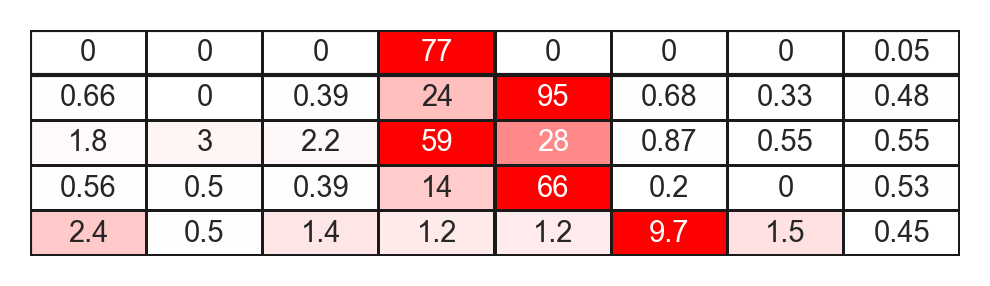

In [41]:
sns_df1=df_cat_cluster_ratio2
sns_df2=df_cat_cluster_ratio2_a

N=sns_df1.shape[0]
fig=plt.figure(figsize=(4,0.2*N))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,vmin=0,vmax=1,cmap=wr,annot=sns_df1,fmt=".2g",
           xticklabels=0,yticklabels=0,cbar=False,ax=ax,annot_kws={"fontsize":7},linecolor="k",linewidths=0.5)
ax.set_xlabel("")

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)

#plt.savefig(store+"table_summary_genomic1.png",dpi=300,bbox_inches="tight")

In [42]:
cont_list=['TMB_log10','indel_count_log10','MSI_score','CNV_burden', 'HRD_score']
for cont in cont_list:
    df.loc[:,cont+"_z"]=stats.zscore(df.loc[:,cont],nan_policy="omit")

cont_list_z=[cont+"_z" for cont in cont_list]

In [43]:
mean_by_cluster=df.groupby("cluster_m2_names").mean()[cont_list].T
mean_by_cluster=mean_by_cluster.loc[:, cluster_orders]
mean_by_cluster

cluster_m2_names,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
TMB_log10,2.221316,2.510392,2.012553,3.596344,2.726495,1.664129,0.568045,1.378593
indel_count_log10,0.983545,0.587305,0.624167,1.579044,2.153386,0.748148,0.282245,0.506840
MSI_score,0.277135,0.110180,0.213609,4.769438,21.662796,0.425538,0.160735,0.250845
CNV_burden,55.548913,51.612584,46.753588,6.284246,15.523733,51.132327,25.720354,36.038275
HRD_score,30.722857,17.182741,25.409852,2.316456,5.343558,26.962553,8.270659,14.695100


In [44]:
mean_by_cluster_z=df.groupby("cluster_m2_names").mean()[cont_list_z].T
mean_by_cluster_z=mean_by_cluster_z.loc[:, cluster_orders]
mean_by_cluster_z

cluster_m2_names,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
TMB_log10_z,0.819750,1.221196,0.529836,2.729285,1.521304,0.045971,-1.476188,-0.350560
indel_count_log10_z,0.652530,-0.166690,-0.090480,1.883719,3.071164,0.165851,-0.797400,-0.333052
MSI_score_z,-0.163515,-0.199785,-0.177316,0.812438,4.482521,-0.131274,-0.188802,-0.169226
CNV_burden_z,0.460283,0.335812,0.182165,-1.097520,-0.805357,0.320626,-0.482929,-0.156665
HRD_score_z,0.650945,-0.113766,0.350880,-0.953375,-0.782412,0.438573,-0.617097,-0.254261


TMB_log10
indel_count_log10
MSI_score
CNV_burden
HRD_score


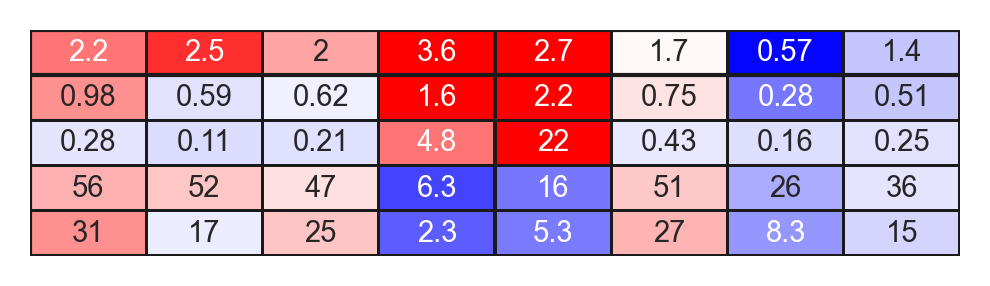

In [45]:
sns_df1=mean_by_cluster
sns_df2=mean_by_cluster_z

N=sns_df1.shape[0]
fig=plt.figure(figsize=(4,0.2*N))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,vmin=-1.5,vmax=1.5,cmap=bwr,annot=sns_df1,fmt=".2g",
           xticklabels=0,yticklabels=0,cbar=False,ax=ax,annot_kws={"fontsize":7},linecolor="k",linewidths=0.5)
ax.set_xlabel("")

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)

for i in sns_df1.index:
    print(i)
    
#plt.savefig(store+"table_summary_genomic2.png",dpi=300,bbox_inches="tight")

In [46]:
cont_list=["CD8A_log","GZMB_log","IFNG_log","PDCD1_log","CTLA4_log", "CYT_log","GEP_score"]
cont_list_z=[cont+"_z" for cont in cont_list]

In [47]:
mean_by_cluster=df.groupby("cluster_m2_names").mean()[cont_list].T
mean_by_cluster=mean_by_cluster.loc[:, cluster_orders]
mean_by_cluster

cluster_m2_names,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
CD8A_log,5.197556,5.378664,5.046330,5.300987,5.318787,4.774315,4.826316,4.396304
GZMB_log,4.689118,4.461388,4.642936,5.003063,4.946106,3.688438,3.421196,3.329275
IFNG_log,1.957213,2.127351,1.977085,2.250468,2.131711,1.247311,1.256938,0.958016
PDCD1_log,3.672979,3.928318,3.526114,4.186582,3.971195,3.191454,3.177575,2.839919
CTLA4_log,3.747184,4.108541,3.814846,3.710101,3.739207,2.974457,2.782881,2.804295
CYT_log,5.018655,4.887140,4.834337,5.158759,5.209249,4.506828,4.334053,4.057764
GEP_score,108.593112,108.677576,107.235678,107.741734,108.031301,101.224632,99.322445,95.310720


In [48]:
mean_by_cluster_z=df.groupby("cluster_m2_names").mean()[cont_list_z].T
mean_by_cluster_z=mean_by_cluster_z.loc[:, cluster_orders]
mean_by_cluster_z

cluster_m2_names,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
CD8A_log_z,0.247739,0.372514,0.143575,0.318987,0.331280,-0.043810,-0.007989,-0.304222
GZMB_log_z,0.507864,0.368536,0.479615,0.699911,0.665094,-0.104292,-0.267772,-0.324007
IFNG_log_z,0.424435,0.550890,0.439192,0.642468,0.554198,-0.103382,-0.096256,-0.318500
PDCD1_log_z,0.288738,0.469885,0.184525,0.653165,0.500310,-0.052926,-0.062772,-0.302346
CTLA4_log_z,0.423446,0.680464,0.471569,0.397101,0.417772,-0.126148,-0.262394,-0.247164
CYT_log_z,0.363439,0.268118,0.229853,0.464899,0.501547,-0.007479,-0.132680,-0.332909
GEP_score_z,0.410297,0.414917,0.336064,0.363737,0.379572,0.007336,-0.096690,-0.316078


CD8A
GZMB
IFNG
PDCD1
CTLA4
CYT
GEP_score


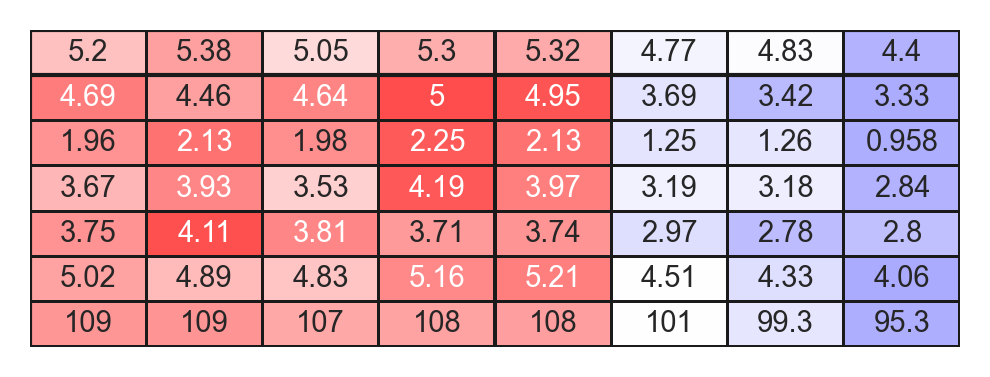

In [49]:
sns_df1=mean_by_cluster
sns_df2=mean_by_cluster_z

N=sns_df1.shape[0]
fig=plt.figure(figsize=(4,0.2*N))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,vmin=-1,vmax=1,cmap=bwr,annot=sns_df1,fmt=".3g",
           xticklabels=0,yticklabels=0,cbar=False,ax=ax,annot_kws={"fontsize":7},linecolor="k",linewidths=0.5)
ax.set_xlabel("")

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)

for i in sns_df1.index:
    print(i.replace("_log",""))
    
#plt.savefig(store+"table_summary_gexp.png",dpi=300,bbox_inches="tight")

# Survival difference

In [50]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

# make function
def KMcurve(data, duration="OS",duration_limit=None,event="Death",category=None,
                continuous=False, pct=None,ax=None,colors=None,group_order=None,
                linewidth=None,linestyle=None,weightings=None):
    """ if you set continuous category, set pct list of percentiles from  0 to 100 """
    """ weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category]) 
        if continuous:
            if len(pct)==0:
                print("pct were set as 50!")
                pct=[50]
            bins=[  np.min(data[category]) ]
            for i in range(len(pct)):
                bins.append( np.percentile(  data[category] , pct[i]  ) )
            bins.append(np.max(data[category]) )
            labels=[ category+"_"+str(i) for i in range(len(pct)+1) ]
            data[category]=pd.cut( data[category], bins=bins,labels=labels
                                 ,duplicates='drop',right=False)
            # divide samples by categories
            numbers, groups = pd.factorize(data[category])   
        else:
            numbers, groups = pd.factorize(data[category])
        
        # plot each group in one figure 
        print(numbers[:10],list(groups))
        if group_order:
            groups=group_order
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} ($n$={})".format(group, group_size) )
            # plot
            options={}
            if colors:
                options["color"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            kmf.plot(ax=ax,ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 1})
        
        if data[category].dtype in ["int","float"]:
            print("KM plot stratified by "+ category +" div-percentile "+str(pct) )
        else:
            print("KM plot stratified by "+ category)
            
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p=", res.summary.iloc[0,1])   
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p=", res.summary.iloc[0,1])
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    ax.legend(title="",frameon=True,fontsize=8,edgecolor="k")
    ax.set_xlabel(duration)
    ax.set_ylabel("survival ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

[0 0 0 0 0 0 0 0 0 0] ['SMK', 'UVL', 'APB', 'POL', 'MRD', 'HRD', 'GNS', 'AGE']
KM plot stratified by cluster_m2_names
cluster_m2_names multivariate log rank p= 3.1940902223546516e-39


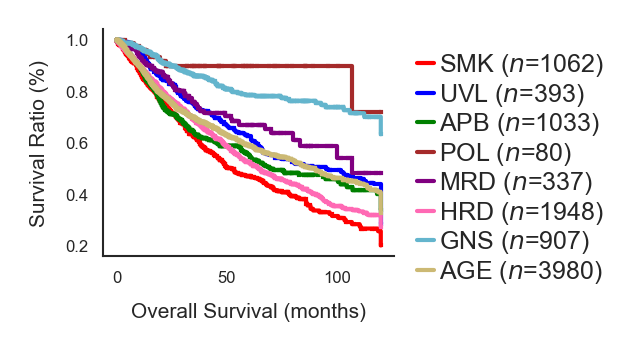

In [51]:
input_df=df.copy()

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category="cluster_m2_names",group_order=cluster_orders,
        colors=cluster_colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=6,bbox_to_anchor=(1, 1),handlelength=0.7
           ,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_all.png",dpi=300,bbox_inches="tight")

[0 0 0 0 0 0 0 0 0 0] ['Others', 'POL+MRD']
KM plot stratified by POL+MRD
POL+MRD simple log rank p= 0.0019695948109615183


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


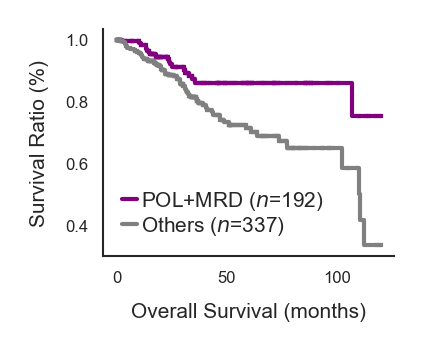

In [52]:
input_df=df.copy()
cancer="UCEC"
cat="POL+MRD"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x in ["POL","MRD"] else "Others" for x in input_df["cluster_m2_names"]  ] 

group_order=[cat, "Others"]
colors=["purple","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_UCEC.png",dpi=300,bbox_inches="tight")

[0 0 0 0 0 0 0 0 0 0] ['Others', 'APB']
KM plot stratified by APB
APB simple log rank p= 0.005028842107398078


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


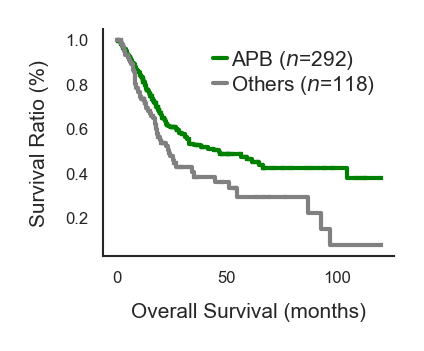

In [53]:
input_df=df.copy()
cancer="BLCA"
cat="APB"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x ==cat else "Others" for x in input_df["cluster_m2_names"]  ] 

group_order=[cat,"Others"]
colors=["green","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_BLCA.png",dpi=300,bbox_inches="tight")

[0 0 0 0 0 0 0 0 0 0] ['SMK', 'Others']
KM plot stratified by SMK
SMK simple log rank p= 0.014376130084522487


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


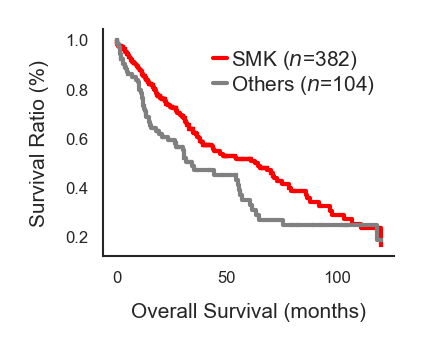

In [54]:
input_df=df.copy()
cancer="LUSC"
cat="SMK"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x ==cat else "Others" for x in input_df["cluster_m2_names"]  ] 

group_order=[cat,"Others"]
colors=["red","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_LUSC.png",dpi=300,bbox_inches="tight")

[0 0 0 0 1 1 1 1 1 1] ['Others', 'UVL']
KM plot stratified by UVL
UVL simple log rank p= 1.0424055263010313e-05


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


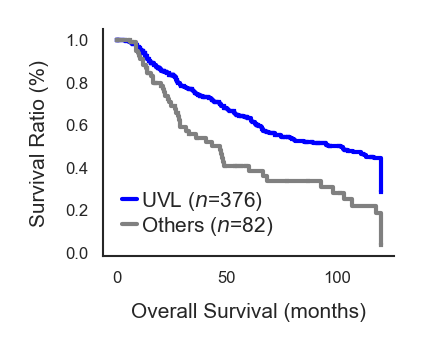

In [55]:
input_df=df.copy()
cancer="SKCM"
cat="UVL"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x ==cat else "Others" for x in input_df["cluster_m2_names"]  ] 

group_order=[cat,"Others"]
colors=["blue","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_SKCM.png",dpi=300,bbox_inches="tight")

[0 0 0 0 0 0 0 0 0 0] ['Others', 'AGE']
KM plot stratified by AGE
AGE simple log rank p= 0.008468499211624356


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


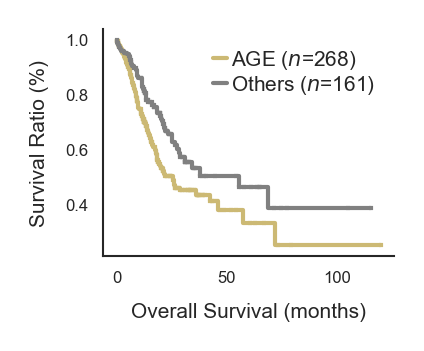

In [56]:
input_df=df.copy()
cancer="STAD"
cat="AGE"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x ==cat else "Others" for x in input_df["cluster_m2_names"]  ] 

group_order=[cat,"Others"]
colors=["y","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_STAD.png",dpi=300,bbox_inches="tight")

[0 0 0 0 0 0 0 0 0 0] ['Others', 'AGE+GNS']
KM plot stratified by AGE+GNS
AGE+GNS simple log rank p= 0.0008226612572946546


/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


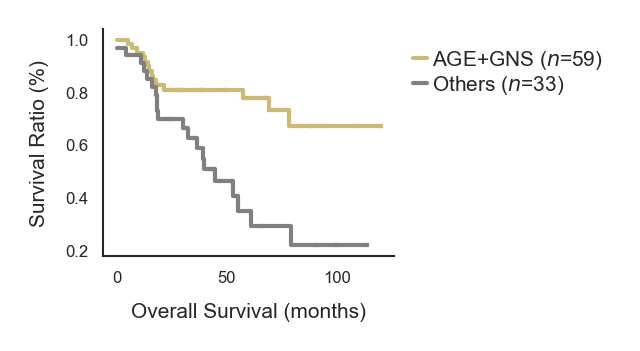

In [59]:
input_df=df.copy()
cancer="ACC"
cat="AGE+GNS"
input_df=df[df["CancerType"]==cancer]
input_df[cat]= [ cat if x in ["AGE","GNS"] else "Others" for x in input_df["cluster_m2_names"]  ] 
group_order=[cat,"Others"]
colors=["y","grey"]

fig=plt.figure(figsize=(1.25,1))
ax=fig.add_subplot(111)
KMcurve(data=input_df,category=cat,group_order=group_order,
        colors=colors,duration_limit=120,linewidth=1,ax=ax)
ax.set_xlabel("Overall Survival (months)",fontsize=5)
ax.set_ylabel("Survival Ratio (%)",fontsize=5)
ax.tick_params(labelsize=4)
ax.legend(bbox_to_anchor=(1,1),frameon=False,edgecolor="k",fontsize=5,handlelength=0.7,labelspacing=0.1,handletextpad=0.2)

#plt.savefig(store+"KM_subtype_ACC.png",dpi=300,bbox_inches="tight")

# ICI monotherapy responce info by cancer-type

In [60]:
ici_info=pd.read_csv("../data/ICI_response_rate_per_cancertype.tsv"
                     ,index_col=2)
ici_info=ici_info[~ici_info.index.isna()]
ici_info=ici_info.sort_values("ORR",ascending=False)
ici_info.drop("UCEC",axis=0,inplace=True)
ici_info

,original,TCGA,PD1/L1 Responders,PD1/L1 1 Total Treated,PD1/L1 ORR,ORR,Note
TCGA_set,,,,,,,
UCEC_MMRd,Endometrial - MSI,UCEC_MMRd,97.0,216.0,0.449074,44.907407,From_papers
SKCM,Melanoma,SKCM,323.0,872.0,0.370413,37.041284,NaN
nonCRC_MMRd,"MSI cancers, Non‐colorectal",nonCRC_MMRd,37.0,110.0,0.336364,33.636364,NaN
CRC_MMRd,Colorectal - MSI high,CRC_MMRd,42.0,135.0,0.311111,31.111111,NaN
KRC,Renal Cell,KRC,112.0,472.0,0.237288,23.728814,NaN
CESC,Cervical Cancer,CESC,13.0,66.0,0.196970,19.696970,NaN
BLCA,Urothelial/Bladder,BLCA,196.0,1080.0,0.181481,18.148148,NaN
LUSC,Non-small cell lung cancer - squamous,LUSC,67.0,385.0,0.174026,17.402597,NaN
LIHC,Hepatocellular Carcinoma,LIHC,70.0,405.0,0.172840,17.283951,NaN


In [61]:
cancer_icires_orders=list(ici_info.index)
rest=['LGG', 'UCS', 'KICH','THCA', 'PCPG']

In [62]:
df["CancerType2"]=df.CancerType.replace({'STAD':"STES","ESCA":"STES",'KIRP':"KRC",'KIRC':"KRC"})

In [63]:
# divide CRC,UCEC into MSI and MSS
cancertype3=[]
for i,cancer in enumerate(df.CancerType2):
    if cancer=="CRC":
        if (df["MSI_annotation"][i]==1.0) | (df["MSI_high"][i]==1.0):
            cancertype3.append("CRC_MMRd")    
        else:
            cancertype3.append("CRC_MMRp")
    elif cancer=="UCEC":
        if (df["MSI_annotation"][i]==1.0) | (df["MSI_high"][i]==1.0):
            cancertype3.append("UCEC_MMRd")    
        else:
            cancertype3.append("UCEC_MMRp")
    else:
        cancertype3.append(cancer)
df["CancerType3"]=cancertype3

In [64]:
# make nonCRC_MMRD by MSI annotation & MSIsensor score
cancertype_nonCRC_MMRD=[]
for i,cancer in enumerate(df.CancerType2):
    if cancer=="CRC":
        cancertype_nonCRC_MMRD.append(0)
    elif (df["MSI_annotation"][i]==1.0) | (df["MSI_high"][i]==1.0) :
        cancertype_nonCRC_MMRD.append(1)    
    else:
        cancertype_nonCRC_MMRD.append(0)
df["nonCRC_MMRd"]=cancertype_nonCRC_MMRD

In [65]:
dict_cluster_cancer_count={}
for cancer in df.CancerType3.unique():
    target_df=df[df.CancerType3==cancer]
    dict_cluster_cancer_count[cancer]=dict( Counter(target_df["cluster_m2_names"]))

In [66]:
dict_cluster_cancer_count["nonCRC_MMRd"]=dict( Counter( df[df["nonCRC_MMRd"]==True]["cluster_m2_names"]) )

In [67]:
df_cluster_cancer_count=pd.DataFrame(dict_cluster_cancer_count).fillna(0)
df_cluster_cancer_count=df_cluster_cancer_count.loc[cluster_orders,cancer_icires_orders+rest]
df_cluster_cancer_count

,UCEC_MMRd,SKCM,nonCRC_MMRd,CRC_MMRd,KRC,CESC,BLCA,LUSC,LIHC,LUAD,MESO,HNSC,UCEC_MMRp,STES,OV,SARC,GBM,CHOL,UVM,PRAD,ACC,BRCA,PAAD,TGCT,CRC_MMRp,LGG,UCS,KICH,THCA,PCPG
SMK,5.0,4.0,7.0,0.0,20.0,4.0,22.0,388.0,141.0,335.0,0.0,63.0,3.0,17.0,25.0,7.0,3.0,2.0,0.0,0.0,4.0,20,0.0,0.0,9,0.0,0.0,0.0,0.0,0.0
UVL,0.0,384.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0
APB,1.0,1.0,3.0,1.0,4.0,213.0,294.0,41.0,1.0,29.0,0.0,190.0,27.0,41.0,3.0,1.0,0.0,3.0,0.0,0.0,1.0,157,6.0,0.0,6,1.0,3.0,0.0,12.0,0.0
POL,13.0,0.0,18.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2,1.0,0.0,11,1.0,1.0,0.0,0.0,0.0
MRD,137.0,1.0,252.0,71.0,1.0,6.0,0.0,2.0,2.0,1.0,1.0,4.0,2.0,82.0,1.0,3.0,3.0,1.0,0.0,3.0,4.0,8,0.0,0.0,3,1.0,1.0,1.0,0.0,0.0
HRD,0.0,23.0,12.0,1.0,329.0,17.0,41.0,33.0,90.0,53.0,36.0,59.0,86.0,94.0,315.0,107.0,79.0,15.0,8.0,61.0,24.0,297,14.0,9.0,59,50.0,19.0,6.0,26.0,5.0
GNS,0.0,21.0,3.0,0.0,84.0,2.0,4.0,7.0,9.0,16.0,17.0,9.0,5.0,7.0,30.0,18.0,3.0,6.0,35.0,58.0,17.0,55,16.0,91.0,2,27.0,0.0,13.0,251.0,106.0
AGE,7.0,33.0,15.0,6.0,179.0,45.0,48.0,18.0,121.0,81.0,28.0,179.0,203.0,377.0,61.0,96.0,299.0,18.0,37.0,372.0,42.0,445,140.0,28.0,361,427.0,33.0,46.0,202.0,68.0


In [68]:
# convert  to ratio
count_sums=df_cluster_cancer_count.apply(np.sum)
df_cluster_cancer_count_ratio=df_cluster_cancer_count/count_sums
df_cluster_cancer_count_ratio

,UCEC_MMRd,SKCM,nonCRC_MMRd,CRC_MMRd,KRC,CESC,BLCA,LUSC,LIHC,LUAD,MESO,HNSC,UCEC_MMRp,STES,OV,SARC,GBM,CHOL,UVM,PRAD,ACC,BRCA,PAAD,TGCT,CRC_MMRp,LGG,UCS,KICH,THCA,PCPG
SMK,0.030675,0.008565,0.022581,0.000000,0.032415,0.013841,0.053398,0.788618,0.387363,0.650485,0.000000,0.124260,0.008174,0.027375,0.057471,0.029536,0.007692,0.044444,0.0000,0.000000,0.043478,0.020305,0.000000,0.000000,0.019912,0.000000,0.000000,0.000000,0.000000,0.000000
UVL,0.000000,0.822270,0.000000,0.000000,0.000000,0.000000,0.004854,0.006098,0.000000,0.000000,0.000000,0.005917,0.000000,0.000000,0.000000,0.021097,0.002564,0.000000,0.0000,0.000000,0.000000,0.001015,0.000000,0.000000,0.002212,0.000000,0.000000,0.000000,0.002033,0.000000
APB,0.006135,0.002141,0.009677,0.012346,0.006483,0.737024,0.713592,0.083333,0.002747,0.056311,0.000000,0.374753,0.073569,0.066023,0.006897,0.004219,0.000000,0.066667,0.0000,0.000000,0.010870,0.159391,0.033898,0.000000,0.013274,0.001972,0.052632,0.000000,0.024390,0.000000
POL,0.079755,0.000000,0.058065,0.024691,0.000000,0.006920,0.002427,0.000000,0.000000,0.000000,0.000000,0.000000,0.111717,0.004831,0.000000,0.000000,0.005128,0.000000,0.0000,0.002020,0.000000,0.002030,0.005650,0.000000,0.024336,0.001972,0.017544,0.000000,0.000000,0.000000
MRD,0.840491,0.002141,0.812903,0.876543,0.001621,0.020761,0.000000,0.004065,0.005495,0.001942,0.012195,0.007890,0.005450,0.132045,0.002299,0.012658,0.007692,0.022222,0.0000,0.006061,0.043478,0.008122,0.000000,0.000000,0.006637,0.001972,0.017544,0.015152,0.000000,0.000000
HRD,0.000000,0.049251,0.038710,0.012346,0.533225,0.058824,0.099515,0.067073,0.247253,0.102913,0.439024,0.116371,0.234332,0.151369,0.724138,0.451477,0.202564,0.333333,0.1000,0.123232,0.260870,0.301523,0.079096,0.070312,0.130531,0.098619,0.333333,0.090909,0.052846,0.027933
GNS,0.000000,0.044968,0.009677,0.000000,0.136143,0.006920,0.009709,0.014228,0.024725,0.031068,0.207317,0.017751,0.013624,0.011272,0.068966,0.075949,0.007692,0.133333,0.4375,0.117172,0.184783,0.055838,0.090395,0.710938,0.004425,0.053254,0.000000,0.196970,0.510163,0.592179
AGE,0.042945,0.070664,0.048387,0.074074,0.290113,0.155709,0.116505,0.036585,0.332418,0.157282,0.341463,0.353057,0.553134,0.607085,0.140230,0.405063,0.766667,0.400000,0.4625,0.751515,0.456522,0.451777,0.790960,0.218750,0.798673,0.842209,0.578947,0.696970,0.410569,0.379888


In [69]:
sig_cluster_ratio=pd.DataFrame( np.sum( df_cluster_cancer_count_ratio.loc[["SMK","UVL","APB","POL","MRD"],:],axis=0) )
sig_cluster_ratio.columns=["SCR"]

In [70]:
responsive_rate_ordered=ici_info.reindex(cancer_icires_orders)[["ORR"]]

In [71]:
df_orr_scr=pd.merge(responsive_rate_ordered,sig_cluster_ratio,left_index=True,right_index=True,how="left")

In [72]:
df_orr_scr["FDA_approved"]=[ int( x in approved_order[0:11] )  for x in df_orr_scr.index] 
df_orr_scr.loc[["nonCRC_MMRd","CRC_MMRd","KRC","STES","UCEC_MMRd"],"FDA_approved"]=1
df_orr_scr

,ORR,SCR,FDA_approved
TCGA_set,,,
UCEC_MMRd,44.907407,0.957055,1
SKCM,37.041284,0.835118,1
nonCRC_MMRd,33.636364,0.903226,1
CRC_MMRd,31.111111,0.913580,1
KRC,23.728814,0.040519,1
CESC,19.696970,0.778547,1
BLCA,18.148148,0.774272,1
LUSC,17.402597,0.882114,1
LIHC,17.283951,0.395604,1


R2 0.6364576550555561
pearson (0.7977829623748278, 1.7840405899844909e-06)


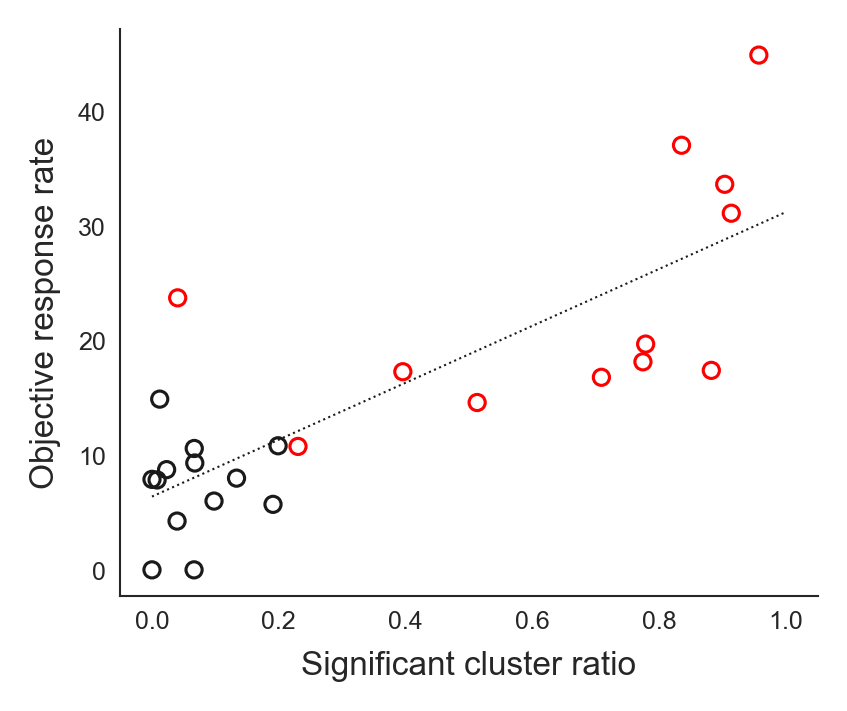

In [73]:
fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
val1="SCR"
val2="ORR"
plt_df=df_orr_scr.dropna()
x=plt_df[val1]
y=plt_df[val2]
colors=[ "red" if x==1.0 else "k" for x in plt_df["FDA_approved"]]
ax.scatter(x,y,edgecolor=colors,s=15,marker="o",fc="None",lw=0.75) #"w",edgecolors=c
ax.set_xlabel("Significant cluster ratio",fontsize=8)
ax.set_ylabel("Objective response rate",fontsize=8)
ax.tick_params(labelsize=6)

res=stats.linregress(x,y)
print("R2", res.rvalue**2)

ax.plot([0,1], [ res[1], res[0]+res[1]],c="k",ls="dotted")

print( "pearson",stats.pearsonr(x,y) )

#print( "spearman",stats.spearmanr(x,y) )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig(store+"Cor_ICI_vs_SCR.png",dpi=300,bbox_inches="tight",transparent=True)

UCEC_MMRd
SKCM
nonCRC_MMRd
CRC_MMRd
KRC
CESC
BLCA
LUSC
LIHC
LUAD
MESO
HNSC
UCEC_MMRp
STES
OV
SARC
GBM
CHOL
UVM
PRAD
ACC
BRCA
PAAD
TGCT
CRC_MMRp
LGG
UCS
KICH
THCA
PCPG


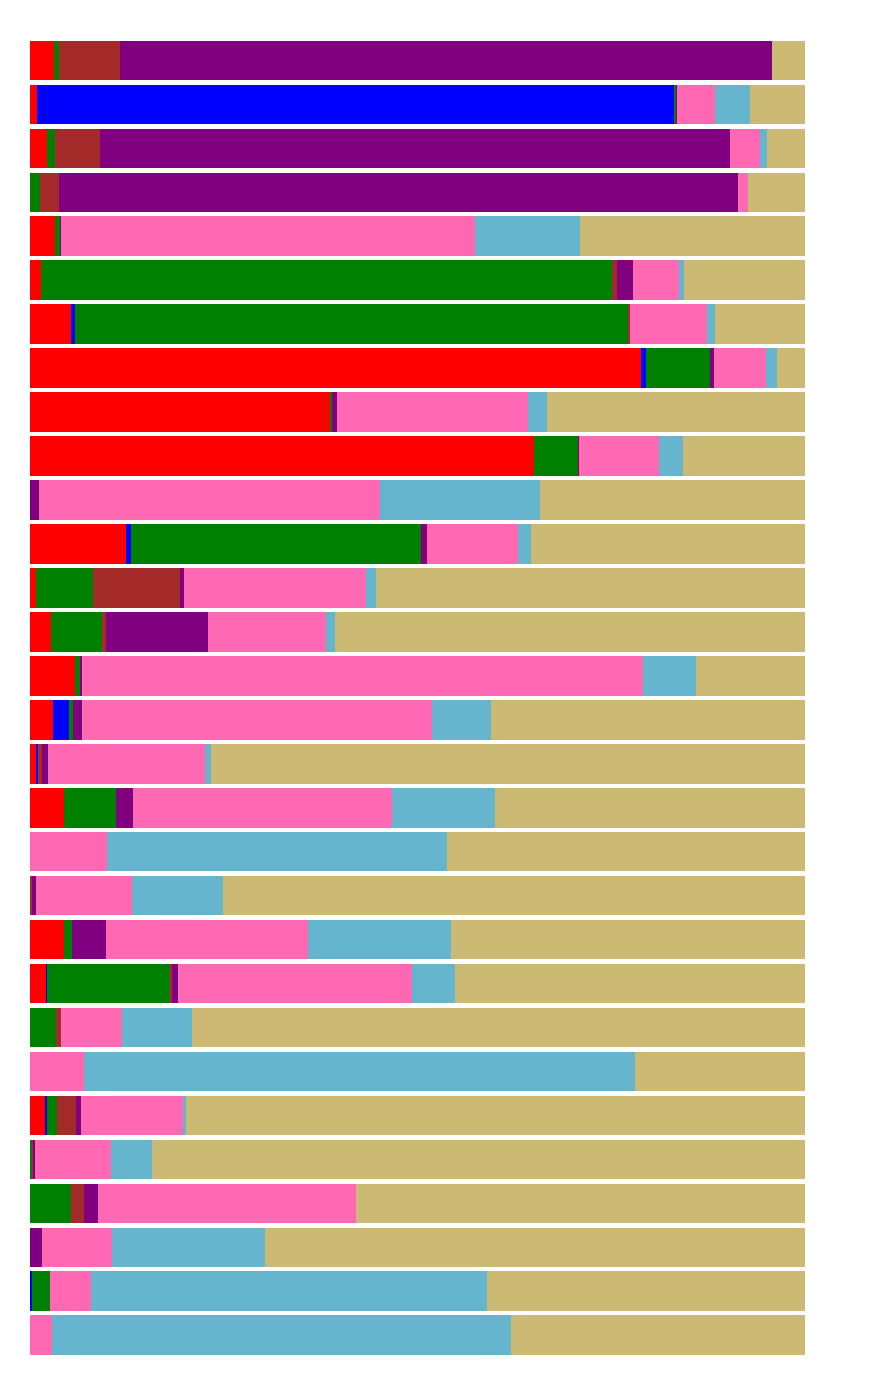

In [74]:
plt_df=df_cluster_cancer_count_ratio.copy()

fig=plt.figure(figsize=(3.5,5.9))
ax=fig.add_subplot(111)
plt_df.T.plot.barh(stacked=True,width=0.9,lw=0,ec="k",color=cluster_colors,ax=ax,)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.legend([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.invert_yaxis()
for i in plt_df.columns:
    print(i)
    
#plt.savefig(store+"ICI_resp_by_cancer_subtype_ratio.png",dpi=300,bbox_inches="tight",transparent=True)

Text(-9.166666666666668, 0.5, '')

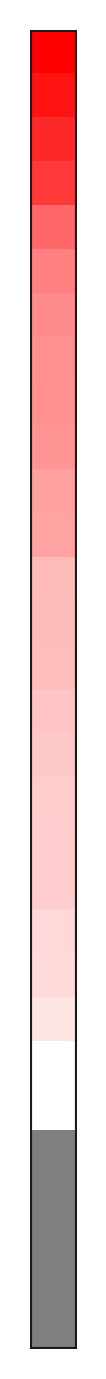

In [75]:
# colorbar
plt.figure(figsize=(0.2,5.825))
plt_df=df_orr_scr
sns_df=pd.DataFrame(plt_df["ORR"])
sns_df=sns_df.reindex( list(sns_df.index)+rest,axis=0)
mask = np.zeros_like(sns_df)
mask[np.triu_indices_from(mask)] = True
g=sns.heatmap(sns_df,cmap=wr,xticklabels=0,yticklabels=0,cbar=False,linewidths=0,vmin=0,vmax=40)
g.set_facecolor("grey")
plt.axvline(x=0, color='k',linewidth=1)
plt.axvline(x=sns_df.shape[1], color='k',linewidth=1)
plt.axhline(y=0, color='k',linewidth=1)
plt.axhline(y=sns_df.shape[0], color='k',linewidth=1)
plt.ylabel("")
#plt.savefig(store+"ICI_resp_by_cancertype_orr.png",dpi=300,bbix_inches="tight")